In [43]:
import numpy as np
import pandas as pd
import csv
import struct
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [44]:
# functions

def read_roti(filename):
    with open(filename, 'rb') as f:
        header_read = False
        date = None
        lats = []
        rows = []
        line = f.readline()
        while not header_read or (line.strip() and not line.strip().startswith(b"END OF ROTIPOLARMAP")):
            if line.strip().startswith(b"START OF ROTIPOLARMAP"):
                header_read = True
            elif line.strip().startswith(b"END OF ROTIPOLARMAP") or line.strip().startswith(b"END OF FILE"):
                break
            elif not header_read:
                pass
            elif line[0:5].strip():
                date = datetime(int(line[0:7]), int(line[7:14]), int(line[14:21]))
            else:
                lat, lon_start, lon_end = float(line[3:9]), float(line[9:15]), float(line[15:21])
                lats.append(lat)

                block = [f.readline() for _ in range(18)]
                row = np.genfromtxt(block)
                rows.append(row.ravel())
            line = f.readline()
        return date, np.array(lats), np.array(rows)

def plot_data_roti(date, lons, lats, map):
    lons, lats = np.meshgrid(lons, lats)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='polar')
    levels = np.arange(0, 0.8, 0.1)
    cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')

    plt.title("ROTI index date: " + str(date))

    plt.colorbar(cc, ax=ax, label="ROTI, TECU/min")

    mlt = np.linspace(0, 24, 49)

    plt.show()

def read_dst(filename):
    with open(filename, 'rb') as f:
        dst_arr = []
        # dst_daily = []
        # date = None
        day = 0
        month = 0
        year = 0

        while day != 31 or month != 12 or year != 2020:
            dst_daily = []
            date = []

            line = f.readline()

            year = int(2000 + int(line[3:5]))
            month = int(line[5:7])
            day = int(line[8:10])
            date.append(day)
            date.append(month)
            date.append(year)
            dst_daily.append(date)

            if len(line) > 121:
                index_string = line[21:len(line)]
            else:
                index_string = line[21:120]
            # index_string = line[21:117]
            # print(index_string)
            # print(type(index_string))
            index_value = index_string.split()
            for value in index_value:
                val = float(value.decode())
                dst_daily.append(val)
            # print(type(index_value))
            dst_daily.pop(-1)
            dst_arr.append(dst_daily)
            # date = datetime(year, month, day)
        
        return dst_arr

def read_f107(filename):
    with open(filename, 'rb') as f:
        f107_arr = []
        day = 0
        month = 0
        year = 0
        
        # we should skip 2 lines in file bc it is head of file
        line = f.readline()
        line = f.readline()
        
        while day != 1 or month != 1 or year != 2021:
            f107_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])
            time = int(line[12:14])
            
            if year < 2010:
                continue
            if day == 1 and month == 1 and year == 2021:
                break
            
            f107_obs = float(line[53:63])
            
            date.append(time)
            date.append(day)
            date.append(month)
            date.append(year)
            
            f107_daily.append(date)
            f107_daily.append(f107_obs)
            
            f107_arr.append(f107_daily)
        return f107_arr

def read_bz_sw(filename):
    with open(filename, 'rb') as f:
        bz_arr = []
        sw_arr = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 1 or month != 1 or year != 2021:
            bz_daily = []
            sw_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)
            
            bz_sw_string = line[18:len(line)]
            bz_sw_value = bz_sw_string.split()
            
            bz_daily.append(date)
            sw_daily.append(date)
            
            for i in range(3):
                if i == 0:
                    bz_daily.append(float(bz_sw_value[i].decode()))
                else:
                    sw_daily.append(float(bz_sw_value[i].decode()))
            
            bz_arr.append(bz_daily)
            sw_arr.append(sw_daily)
            
        # remove date 2021 1 1
        bz_arr.pop(-1)
        sw_arr.pop(-1)
        
    return bz_arr, sw_arr

def read_kp(filename):
    with open(filename, 'rb') as f:
        kp_arr = []
        
        day = 0
        month = 0
        year = 0

        # we should skip first line in file bc it is head of file
        line = f.readline()
        
        while day != 31 or month != 12 or year != 2020:
            kp_daily = []
            date = []

            line = f.readline()

            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])

            date.append(day)
            date.append(month)
            date.append(year)

            kp_daily.append(date)

            kp_str = str(line[25:28].decode())
            
            if kp_str[len(kp_str) - 1] == '+':
                kp_value = float(kp_str[:len(kp_str) - 1]) + 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            elif kp_str[len(kp_str) - 1] == '-':
                kp_value = float(kp_str[:len(kp_str) - 1]) - 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            else:
                kp_value = float(kp_str)

            kp_daily.append(kp_value)
            kp_arr.append(kp_daily)
            
        return kp_arr

def doy2day(doy, year):
    startDate = datetime(year=year, month=1, day=1)
    daysToShift = doy - 1
    endDate = startDate + timedelta(days=daysToShift)
    
    month = endDate.month
    day = endDate.day
    
    return day, month


In [45]:
# data
# kp_data, bz_data, sw_data, f107_data, dst_data

kp_file = '../data/kp/Kp_index.txt'
kp_data = read_kp(kp_file)

bz_sw_file = '../data/imfbz_sw/omni2_daily_Wxi8tQda3U.lst.txt'
bz_data, sw_data = read_bz_sw(bz_sw_file)

f107_file = '../data/f10-7/fluxtable.txt'
f107_data = read_f107(f107_file)

dst_file = '../data/dst/WWW_dstae03359771.dat.txt'
dst_data = read_dst(dst_file)

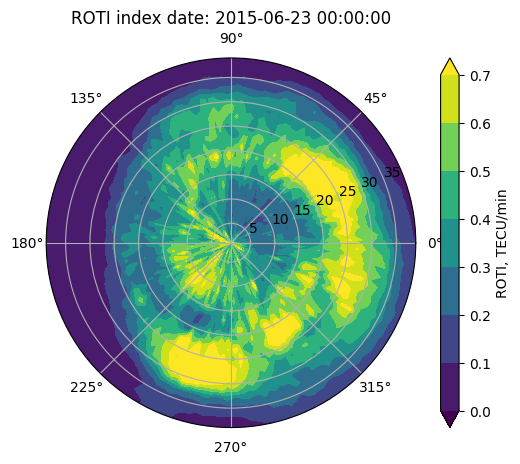

In [46]:
# example of ROTI map
# doy = ["020", "021", "022", "023", "024"]
doy = ["174"]
all_maps = []

for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []

    date, lats, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    # print("lons:\n", lons)
    plot_data_roti(date, lons, lats, map)
